In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.base import TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import logging
import joblib
import os
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)

In [2]:
data = pd.read_csv("data/CompleteDataset.csv", low_memory=False).drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])
data.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,2228,89,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,2154,92,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,2100,94,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,2291,88,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
5,R. Lewandowski,28,Poland,91,91,FC Bayern Munich,€92M,€355K,2143,79,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0


In [ ]:
def value_to_float(x):
    x.split('€')[1]
    if type(x) == float or type(x) == int:
        return x
    if 'M' in x:
        return float(x.split('€')[1].replace('M','')) * 1000000
    if 'K' in x:
        return float(x.split('€')[1].replace('K','')) * 1000
    if '€' in x:
        return float(x.split('€')[1])
    return 0

def clean_stat(value):
    try:
        if '+' in value or '-' in value:
            base, mod = value.split('+') if '+' in value else value.split('-')
            mod = int(mod) if '+' in value else -int(mod)
            return int(base) + mod
        else:
            return int(value)
    except:
        return np.nan
    

def create_features(data):

    df = data.copy()

    columns_with_issues = ['Finishing', 'Composure', 'Dribbling', 'Shot power', 
                        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
                        'Stamina', 'Jumping', 'Ball control', 'Short passing']

    for c in columns_with_issues:
        df[c] = df[c].apply(clean_stat)

    df['Value'] = df['Value'].apply(value_to_float)
    df['Wage'] = df['Wage'].apply(value_to_float)

    df['Primary Position'] = df['Preferred Positions'].apply(lambda x: x.split()[0])
    df['Secondary Positions'] = df['Preferred Positions'].apply(lambda x: ' '.join(x.split()[1:]))

    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)

    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']

    df['isAttacker'] = np.where(df['Attack/Defend Ratio'] > 1, 1.0, 0.0)

    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)

    df['Age Group'] = pd.cut(
                            df['Age'], 
                            bins=[15, 20, 25, 30, 40, 50], 
                            labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend']
                            )
    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']

    df.drop(columns=['Preferred Positions'], inplace=True)
    df.drop_duplicates(inplace=True)

    return df.reset_index(drop=True)

df = create_features(data)

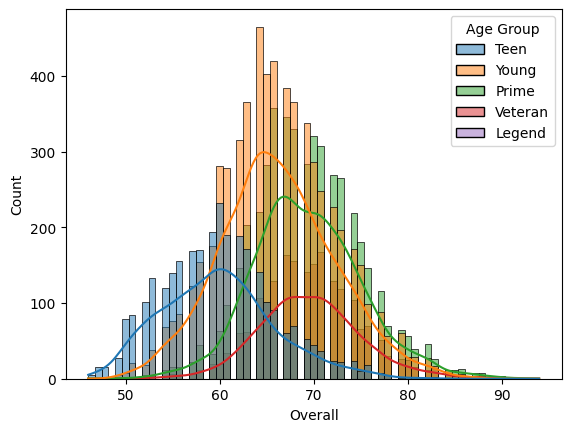

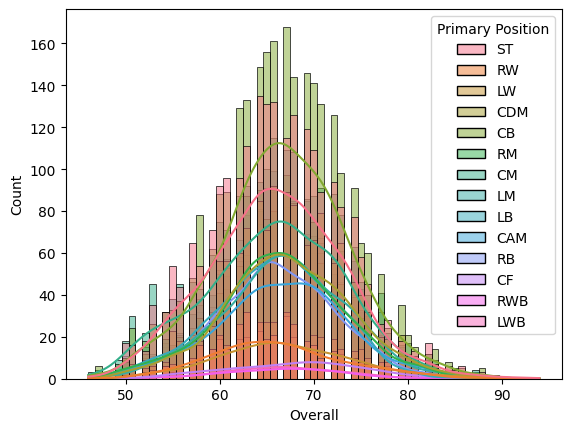

In [ ]:
sns.histplot(data=df, x='Overall', hue='Age Group', kde=True)
plt.show()

sns.histplot(data=df, x='Overall', hue='Primary Position', kde=True)
plt.show()

C:\Users\vince\AppData\Local\Temp\ipykernel_45168\3907592428.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(df.corr(), cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))


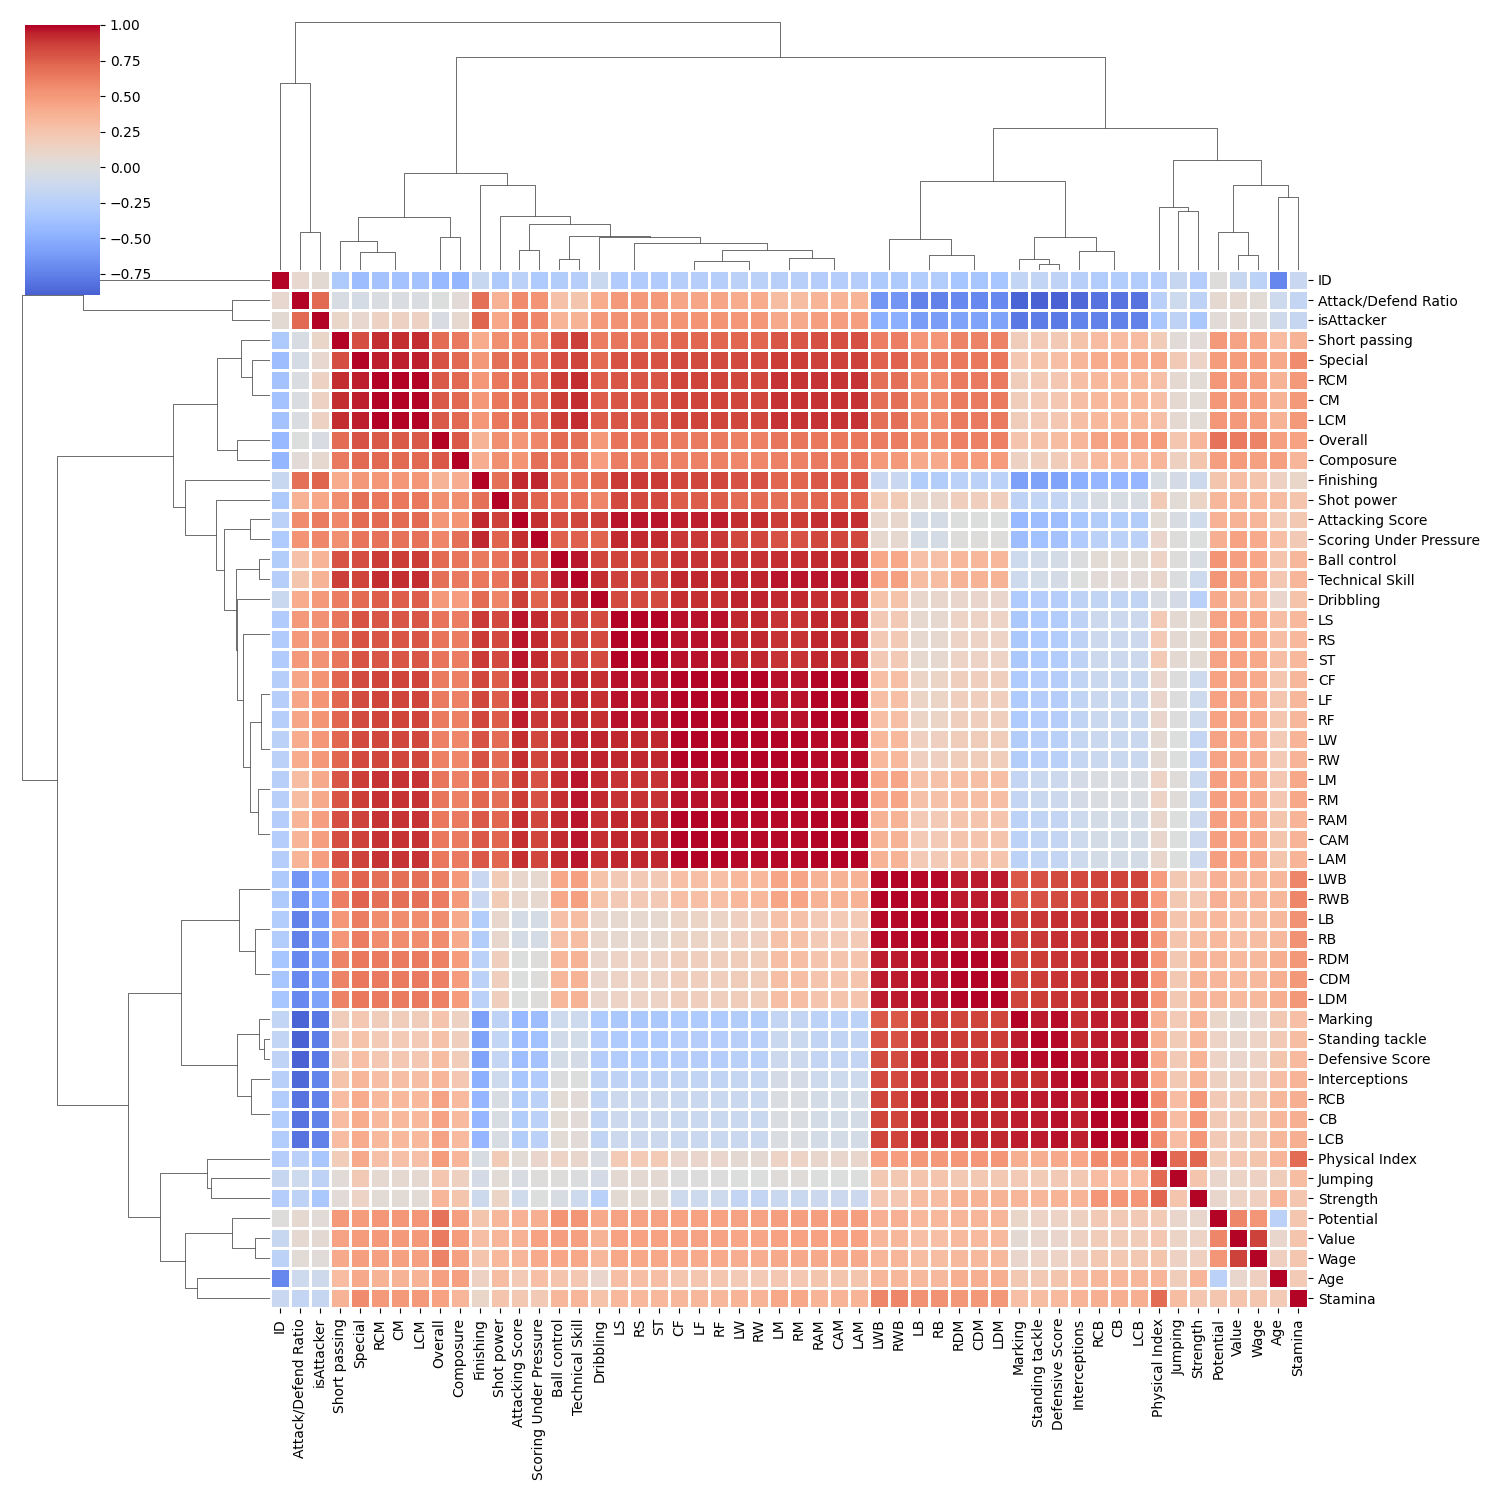

In [5]:
# HIERARCHICAL CLUSTERING CORRELATION
sns.clustermap(df.corr(), cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))
plt.show()

In [ ]:
# These are the most correlated features with the target
target = 'Overall'
correlation = df.corr()[target].sort_values(ascending=False)
correlation = correlation.drop(target)
correlation

C:\Users\vince\AppData\Local\Temp\ipykernel_45168\3700243203.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()[target].sort_values(ascending=False)


Special                   0.795558
Composure                 0.775916
CM                        0.764267
RCM                       0.764267
LCM                       0.764267
Ball control              0.704956
Short passing             0.699537
Technical Skill           0.681393
Potential                 0.672332
RS                        0.664297
LS                        0.664297
ST                        0.664297
LM                        0.655950
RM                        0.655950
LAM                       0.649501
CAM                       0.649501
RAM                       0.649501
LF                        0.635509
CF                        0.635509
RF                        0.635509
Value                     0.635500
RWB                       0.628480
LWB                       0.628480
RW                        0.609244
LW                        0.609244
LDM                       0.606926
RDM                       0.606926
CDM                       0.606926
Wage                

In [ ]:
def model_pipeline(df, target, task_type, subset_frac=0.1, random_state=42):
    try:
        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = categorical_cols.drop(target)
    except:
        categorical_cols = []

    try:
        numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
        numerical_cols = numerical_cols.drop(target)
    except:
        numerical_cols = []

    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    if task_type == 'regression':
        models_list = [
            (RandomForestRegressor(random_state=42), {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20]
            }),
            (LinearRegression(), {
                'fit_intercept': [True, False]
            }),
            (SVR(), {
                'C': [0.1, 1.0],
                'kernel': ['linear', 'rbf']
            }),
            (LGBMRegressor(), {
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200]
            })
        ]
        # We take the negative of the mean squared error to maximize the score
        scoring_metric = 'neg_mean_squared_error'
        
    elif task_type == 'classification':
        models_list = [
            (RandomForestClassifier(random_state=42), {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20]
            }),
            (LogisticRegression(random_state=42), {
                'C': [0.1, 1.0],
                'penalty': ['l1', 'l2']
            }),
            (SVC(random_state=42), {
                'C': [0.1, 1.0],
                'kernel': ['linear', 'rbf']
            }),
            (LGBMClassifier(), {
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200]
            })
        ]
        # We take the accuracy to maximize the score
        scoring_metric = 'accuracy'
    else:
        raise ValueError("task_type must be either 'regression' or 'classification'")

    df_sampled = df.sample(frac=subset_frac, random_state=random_state)
    X = df_sampled.drop(columns=target)
    y = df_sampled[target]

    if task_type == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    pipelines = [
        Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]) for model, _ in models_list
    ]

    param_grids = [
        {
            f'model__{param}': values for param, values in params.items()
        } for model, params in models_list
    ]

    results = []

    for i, (pipeline, param_grid) in tqdm(enumerate(zip(pipelines, param_grids))):
        try:
            grid_search = GridSearchCV(pipeline, 
                                       param_grid, 
                                       cv=5, 
                                       scoring=scoring_metric, 
                                       n_jobs=-1)
            
            grid_search.fit(X_train, y_train)

            best_score = -grid_search.best_score_ if scoring_metric == 'neg_mean_squared_error' else grid_search.best_score_

            print(f"Best score for {pipeline.named_steps['model'].__class__.__name__}: {best_score:.4f}")
            print(f"Best parameters: {grid_search.best_params_}")
            print()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            results.append({
                'model': pipeline.named_steps['model'].__class__.__name__,
                'best_score': best_score,
                'best_params': grid_search.best_params_,
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred,
                'best_model': best_model
            })

            if task_type == 'regression':
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                print(f"Test Set Metrics for {pipeline.named_steps['model'].__class__.__name__}:")
                print(f"MSE: {mse:.4f}, R2: {r2:.4f}")
            else:
                accuracy = accuracy_score(y_test, y_pred)
                # f1 = f1_score(y_test, y_pred, average='weighted')
                # recall = recall_score(y_test, y_pred, average='weighted')
                print(f"Test Set Metrics for {pipeline.named_steps['model'].__class__.__name__}:")
                print(f"Accuracy: {accuracy:.4f}")
                print(classification_report(y_test, y_pred))

            print("------------------------------")

        except Exception as e:
            print(f"An error occurred with model {i+1}: {e}")

    if scoring_metric == 'neg_mean_squared_error':
        best_model_result = min(results, key=lambda x: x['best_score'])
    else:
        best_model_result = max(results, key=lambda x: x['best_score'])

    print(f"Best model: {best_model_result['model']} with score: {best_model_result['best_score']:.4f}")
    print(f"Best parameters: {best_model_result['best_params']}")

    best_model_name = f"models_assignement_1/best_model_{task_type}_{target}.joblib"
    joblib.dump(best_model_result['model'], best_model_name)
    print(f"Best model saved as {best_model_name}")

    return results

In [8]:
results_reg = model_pipeline(df, 
                         target='Overall', 
                         task_type='regression', 
                         subset_frac=1.0, 
                         random_state=42)

1it [03:38, 218.72s/it]

Best score for RandomForestRegressor: 0.1231
Best parameters: {'model__max_depth': None, 'model__n_estimators': 200}

Test Set Metrics for RandomForestRegressor:
MSE: 0.0882, R2: 0.9982
------------------------------


2it [03:39, 90.31s/it] 

Best score for LinearRegression: 3.5226
Best parameters: {'model__fit_intercept': True}

Test Set Metrics for LinearRegression:
MSE: 3.6114, R2: 0.9244
------------------------------
Best score for SVR: 1.0330
Best parameters: {'model__C': 1.0, 'model__kernel': 'rbf'}



3it [04:15, 65.76s/it]

Test Set Metrics for SVR:
MSE: 0.8120, R2: 0.9830
------------------------------


c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 12559, number of used features: 51
[LightGBM] [Info] Start training from score 66.379091


4it [04:22, 65.61s/it]

Best score for LGBMRegressor: 0.1499
Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 200}

Test Set Metrics for LGBMRegressor:
MSE: 0.1181, R2: 0.9975
------------------------------
Best model: RandomForestRegressor with score: 0.1231
Best parameters: {'model__max_depth': None, 'model__n_estimators': 200}
Best model saved as models_assignement_1/best_model_regression_Overall.joblib


In [ ]:
# We can also save the best model to prevent retraining which may take a long time
# best_model_reg_Overall = joblib.load("models_assignement_1/best_model_regression_Overall.joblib")
# best_model_cla_Position = joblib.load("models_assignement_1/best_model_classification_Primary.joblib") 

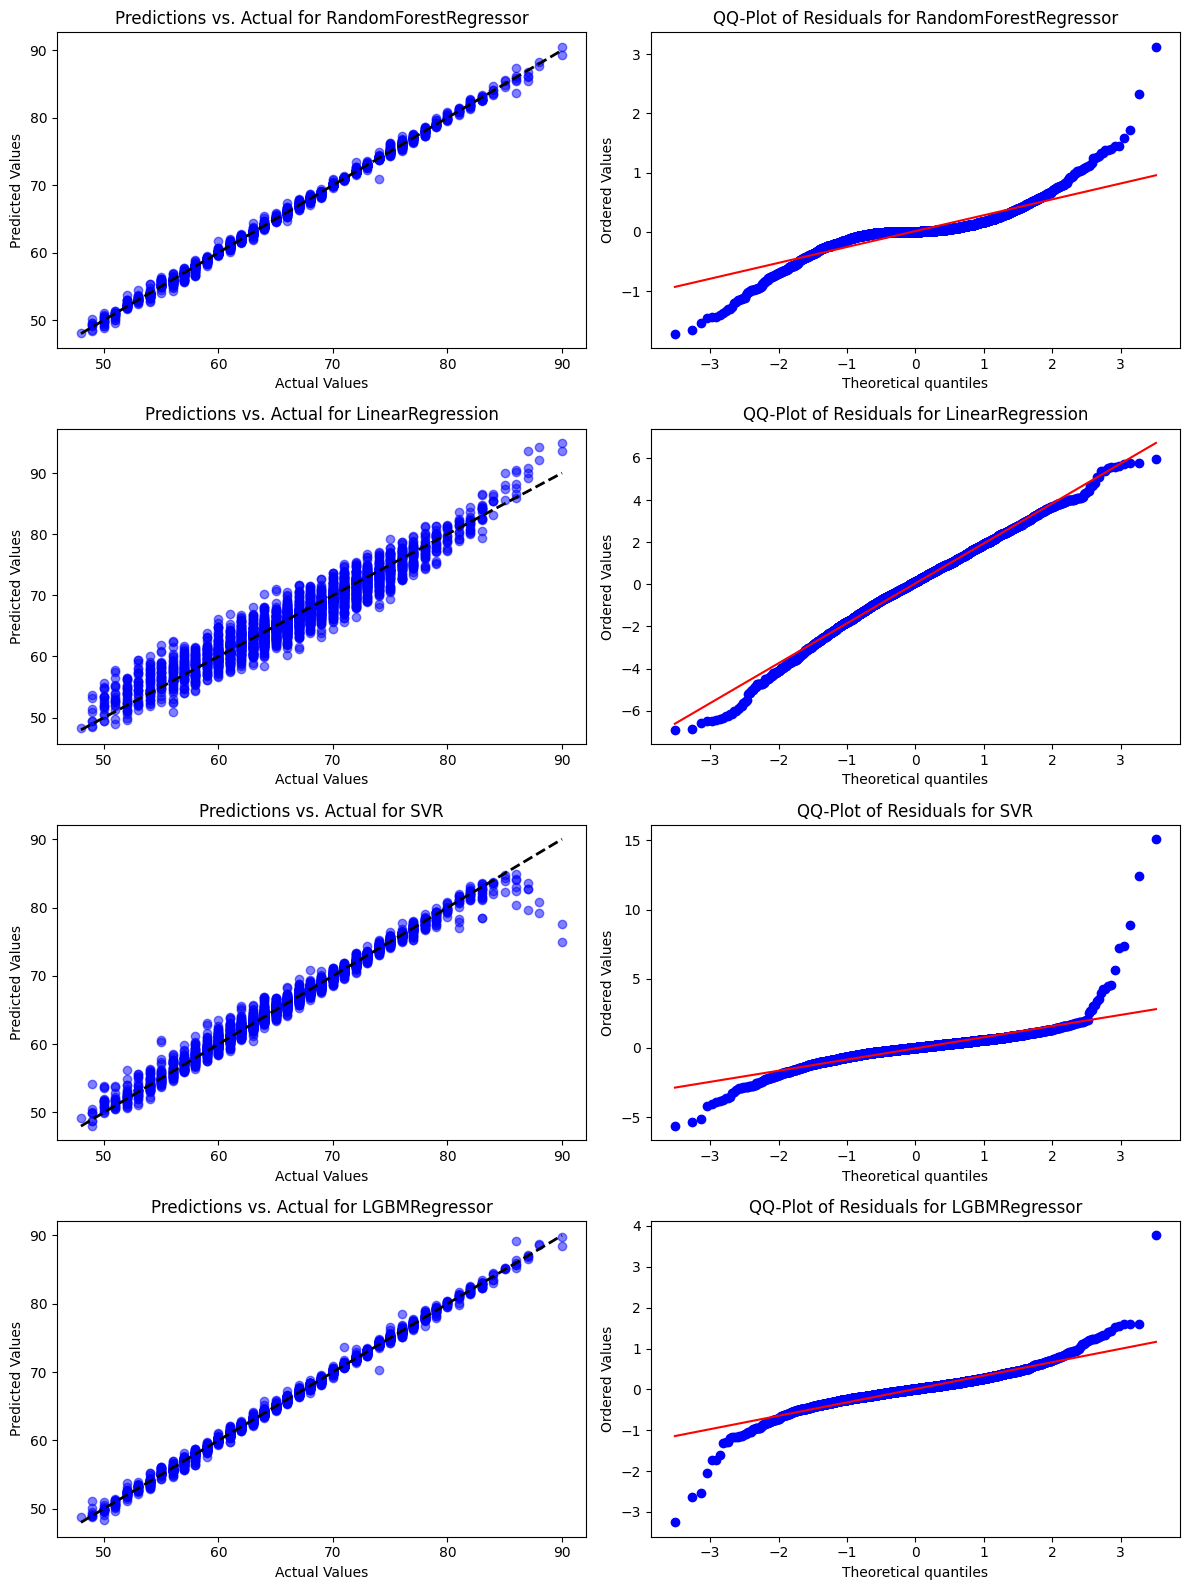

,Model,Best CV Score (Neg MSE),MSE on Test Set,R2 on Test Set,Best Parameters
0,RandomForestRegressor,0.123064,0.088241,0.998152,"{'model__max_depth': None, 'model__n_estimator..."
1,LinearRegression,3.522638,3.611426,0.924367,{'model__fit_intercept': True}
2,SVR,1.033004,0.811957,0.982995,"{'model__C': 1.0, 'model__kernel': 'rbf'}"
3,LGBMRegressor,0.149932,0.118087,0.997527,"{'model__learning_rate': 0.1, 'model__n_estima..."


In [ ]:
model_names = []
best_scores = []
best_params_list = []
mse_scores = []
r2_scores = []
y_pred_list = []

for result in results_reg:
    y_test = result['y_test']
    model_names.append(result['model'])
    best_scores.append(result['best_score'])
    best_params_list.append(result['best_params'])
    y_pred = result['y_pred']
    y_pred_list.append(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

num_models = len(results_reg)
fig, axes = plt.subplots(num_models, 2, figsize=(12, 4*num_models), squeeze=False)

for i in range(num_models):
    y_pred = y_pred_list[i]
    residuals = y_test - y_pred
    
    axes[i, 0].scatter(y_test, y_pred, color='blue', alpha=0.5)
    axes[i, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i, 0].set_xlabel('Actual Values')
    axes[i, 0].set_ylabel('Predicted Values')
    axes[i, 0].set_title(f'Predictions vs. Actual for {model_names[i]}')
    
    stats.probplot(residuals, plot=axes[i, 1])
    axes[i, 1].set_title(f'QQ-Plot of Residuals for {model_names[i]}')

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame({
    'Model': model_names,
    'Best CV Score (Neg MSE)': best_scores,
    'MSE on Test Set': mse_scores,
    'R2 on Test Set': r2_scores,
    'Best Parameters': best_params_list
})

summary_df.to_csv("models_assignement_1/summary_regression_Overall.csv", index=False)
summary_df

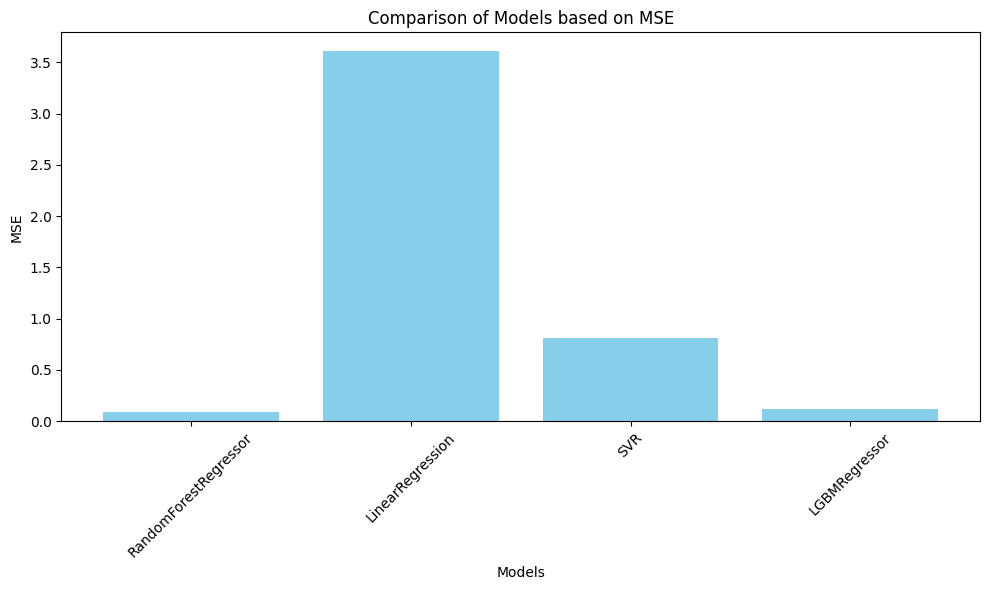

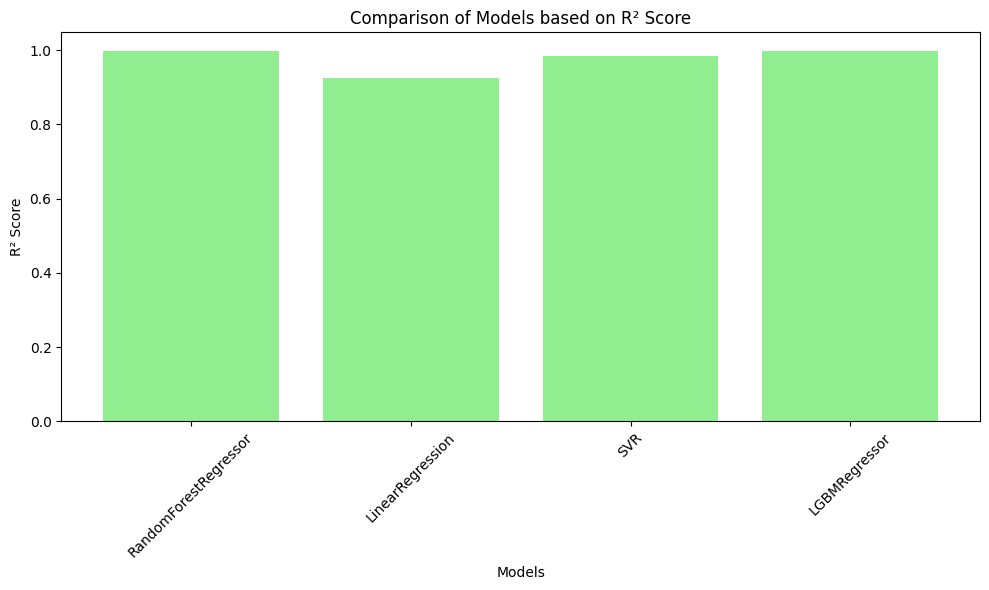

In [11]:
plt.figure(figsize=(10,6))
plt.bar(model_names, mse_scores, color='skyblue')
plt.title('Comparison of Models based on MSE')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.bar(model_names, r2_scores, color='lightgreen')
plt.title('Comparison of Models based on R² Score')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In case the regression model is not acceptable, we trained the models on a classification task. The orginal columns for position is devided into two columns, one for the primary position (the target) and the other for the secondary position. The model is trained to predict the primary position.

This part is the same as the regression model, except for the target column. This part demonstrate the function used for training that was built to be used for both regression and classification tasks and which adapts to the target column and the task type.

In [9]:
results_cla = model_pipeline(df, 
                         target='Primary Position', 
                         task_type='classification',
                         subset_frac=1.0, 
                         random_state=42)

0it [00:00, ?it/s]

Best score for RandomForestClassifier: 0.5118
Best parameters: {'model__max_depth': None, 'model__n_estimators': 200}



c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
1it [09:18, 558.24s

Test Set Metrics for RandomForestClassifier:
Accuracy: 0.5223
              precision    recall  f1-score   support

         CAM       0.52      0.17      0.25       222
          CB       0.55      0.86      0.67       530
         CDM       0.61      0.47      0.54       272
          CF       0.86      0.15      0.26        40
          CM       0.52      0.74      0.61       390
          LB       0.41      0.21      0.27       258
          LM       0.44      0.45      0.44       261
          LW       0.32      0.07      0.12        84
         LWB       1.00      0.04      0.08        24
          RB       0.45      0.16      0.24       237
          RM       0.47      0.37      0.42       265
          RW       0.53      0.11      0.18        85
         RWB       0.00      0.00      0.00        21
          ST       0.54      0.88      0.67       451

    accuracy                           0.52      3140
   macro avg       0.52      0.33      0.34      3140
weighted avg      

c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(X

Best score for LogisticRegression: 0.5406
Best parameters: {'model__C': 0.1, 'model__penalty': 'l2'}



c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2it [12:07, 329.56s

Test Set Metrics for LogisticRegression:
Accuracy: 0.5605
              precision    recall  f1-score   support

         CAM       0.39      0.31      0.34       222
          CB       0.78      0.86      0.82       530
         CDM       0.60      0.53      0.56       272
          CF       1.00      0.12      0.22        40
          CM       0.59      0.71      0.64       390
          LB       0.43      0.40      0.41       258
          LM       0.38      0.44      0.41       261
          LW       0.19      0.06      0.09        84
         LWB       0.00      0.00      0.00        24
          RB       0.38      0.36      0.37       237
          RM       0.40      0.40      0.40       265
          RW       0.38      0.12      0.18        85
         RWB       0.00      0.00      0.00        21
          ST       0.67      0.86      0.75       451

    accuracy                           0.56      3140
   macro avg       0.44      0.37      0.37      3140
weighted avg       0.5

3it [3:53:48, 6252.65s/it]

Test Set Metrics for SVC:
Accuracy: 0.5576
              precision    recall  f1-score   support

         CAM       0.31      0.36      0.33       222
          CB       0.78      0.84      0.81       530
         CDM       0.60      0.57      0.59       272
          CF       0.42      0.20      0.27        40
          CM       0.60      0.71      0.65       390
          LB       0.43      0.39      0.41       258
          LM       0.36      0.40      0.38       261
          LW       0.24      0.13      0.17        84
         LWB       0.17      0.08      0.11        24
          RB       0.38      0.35      0.37       237
          RM       0.44      0.41      0.42       265
          RW       0.28      0.16      0.21        85
         RWB       0.00      0.00      0.00        21
          ST       0.78      0.80      0.79       451

    accuracy                           0.56      3140
   macro avg       0.41      0.39      0.39      3140
weighted avg       0.54      0.56    

4it [3:55:41, 3535.32s/it]

Test Set Metrics for LGBMClassifier:
Accuracy: 0.5707
              precision    recall  f1-score   support

         CAM       0.39      0.33      0.36       222
          CB       0.84      0.85      0.84       530
         CDM       0.58      0.57      0.58       272
          CF       0.75      0.15      0.25        40
          CM       0.58      0.69      0.63       390
          LB       0.41      0.44      0.42       258
          LM       0.37      0.42      0.40       261
          LW       0.16      0.05      0.07        84
         LWB       0.29      0.08      0.13        24
          RB       0.39      0.37      0.38       237
          RM       0.40      0.45      0.42       265
          RW       0.29      0.11      0.16        85
         RWB       0.00      0.00      0.00        21
          ST       0.76      0.86      0.81       451

    accuracy                           0.57      3140
   macro avg       0.44      0.38      0.39      3140
weighted avg       0.55   